If you have counted a total of 10,000 photoelectrons over 10 minutes created from incoming photons at a CCD pixel of a telescope’s camera, what is the noise level or uncertainty in that photoelectron count?


In [249]:
Count_pe = 10000
Noise_level = (Count_pe)**(0.5)
Noise_level

100.0

In [250]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import statistics as stat

Find out your preferred name’s alphabetical order within your team. Retrieve your specific data file for your team number and order number here: https://drive.google.com/drive/folders/11ukgOh-Lal2K58fLnshbD1kM6WRS-b75?usp=share_link . You can read the data file using `numpy.loadtxt()` function. The file contains a 2D image of an elliptical galaxy. In other words, each pixel contains a flux value. The point spread function (PSF) is a Gaussian with 0.3 arcsecond FWHM. Plot `numpy.log10(image)` using the `matplotlib.pyplot.matshow()` function. Each pixel size is 0.05 arcsecond. How large is the full image in the arcsecond unit?


Dimension of the image is = ( 6.050000000000001 , 6.050000000000001 ) arcsecond


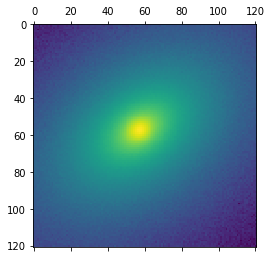

In [277]:
image = np.loadtxt('team_7_order_1.txt')
pixel_size = 0.05
m,n = image.shape[0],image.shape[1]
print("Dimension of the image is = (",pixel_size*m,",",pixel_size*n,") arcsecond")
plt.matshow(np.log10(image))

The unit of each pixel’s flux value is electron/second. The total exposure time for this image is 600 seconds. What is the noise level in each pixel in the electron/second unit? Plot the signal-to-noise ratio map for the image using `matshow()`.

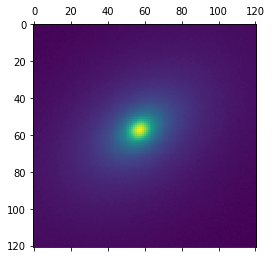

In [305]:
duration = 600
electron_count = image*duration
noise_level = (electron_count**0.5)/duration
snr = image/noise_level
plt.matshow(snr)

Model the flux distribution in the image using an elliptical Sersic function. Don’t forget the PSF in your model. You will need to find the uncertainties of the model parameters using MCMC. Fix nSersic = 4 in your model, but find the best-fit values for other parameters. The other model parameters and their priors are: 

a) x-centroid, x0: prior up to you to choose  

b) y-centroid, y0: prior up to you to choose  

c) scale radius, RSersic: uniform between 0 arcsec and 3 arcsec  

d) axis ratio, q: uniform between 0.4 and 1  

e) position angle, φ:  uniform between 0 and π

f) amplitude: prior is up to you to choose


In [344]:
from astropy.modeling import models
from astropy.convolution import convolve_fft, Gaussian2DKernel

In [345]:
nSersic = 4

def psf_convolvedmodel(amplitude, r_eff, x_0, y_0, q, theta):
    sersic = Sersic2D(amplitude = amplitude,
                     r_eff = r_eff,
                     n=nSersic,
                     x_0=x_0,
                     y_0=y_0,
                     ellip= 1-q,
                     theta=theta)
    FWHM = 0.3/0.05 #pixel
    std = FWHM/(2*np.sqrt(2*np.log(2)))
    kernel = Gaussian2DKernel(x_stddev= std, y_stddev= std)
    x,y = np.meshgrid(np.arange(121), np.arange(121))
    model_img = sersic(x,y)
    model_conv = convolve_fft(model_img, kernel)
    
    return model_conv

In [346]:
x,y = np.meshgrid(np.arange(121), np.arange(121))
flux = image
ferr = noise_level

In [347]:
def get_log_likelihood(params,x,y,flux,ferr):
    """
    Compute the log likelihood value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log likelihood value
    :rtype: float
    """
    # write code
    a, r_eff, x0, y0, q, theta, log_f = params
    
    model = psf_convolvedmodel(a, r_eff, x0, y0, q, theta)
    sigma2 = ferr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))


def get_log_prior(params):
    """
    Get the log prior value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log prior value
    :rtype: float
    """
    # write code
    a, r_eff, x0, y0, q, theta, log_f = params
    if (0 < a and 0 < r_eff < 60 and 
            0 < x0 < 120 and 0 < y0 < 120 and 
            0.4 < q < 1 and 0 < theta < math.pi and
            -20 < log_f < 0):
        return 0.0
    return -np.inf

def get_log_posterior(params,x,y,flux,ferr):
    """
    Compute the log posterior value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log posterior value
    :rtype: float
    """
    log_prior = get_log_prior(params)

    if np.isinf(log_prior):
        return -np.inf
    else:
        return get_log_likelihood(params,x,y,flux,ferr) + log_prior

In [348]:
a_guess = 1
r_eff_guess = 20 
x0_guess = 60
y0_guess = 60
q_guess = 0.5
theta_guess = math.pi/2
f_guess = 0.5

In [354]:
import emcee

init_params = np.array([a_guess, r_eff_guess, x0_guess, 
                            y0_guess, q_guess, theta_guess, np.log(f_guess)]) # insert your initial guess for the model parameters
num_step = 1000
num_walkers = 60
num_params = len(init_params)
init_walker_positions = np.random.normal(loc=init_params, scale=1e-4,
                                        size=(num_walkers, num_params))

sampler = emcee.EnsembleSampler(num_walkers, num_params,
                                get_log_posterior,args = (x,y,flux,ferr))

sampler.run_mcmc(init_walker_positions, num_step, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:46<00:00,  3.49it/s]


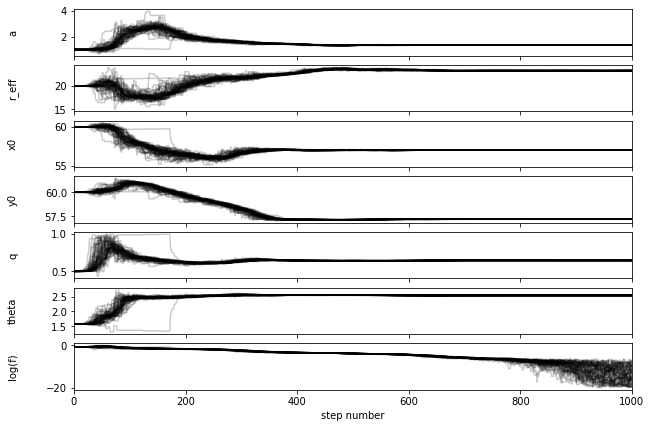

In [355]:
fig, axes = plt.subplots(num_params, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ["a","r_eff","x0","y0","q","theta","log(f)"] # make a list of strings for the labels of your model parameters

for i in range(num_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [356]:
from IPython.display import display, Math

discard = 200
flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)

values = np.empty((0,3)) 
for i in range(num_params):
    percentile_16, median, percentile_84 = np.percentile(
        flat_samples[:, i], [16, 50, 84])
    values = np.vstack((values, np.array([percentile_16, median, percentile_84])))

    text = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}"
    text = text.format(median,
                       median - percentile_16,
                       percentile_84 - median,
                       labels[i])
    display(Math(text))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

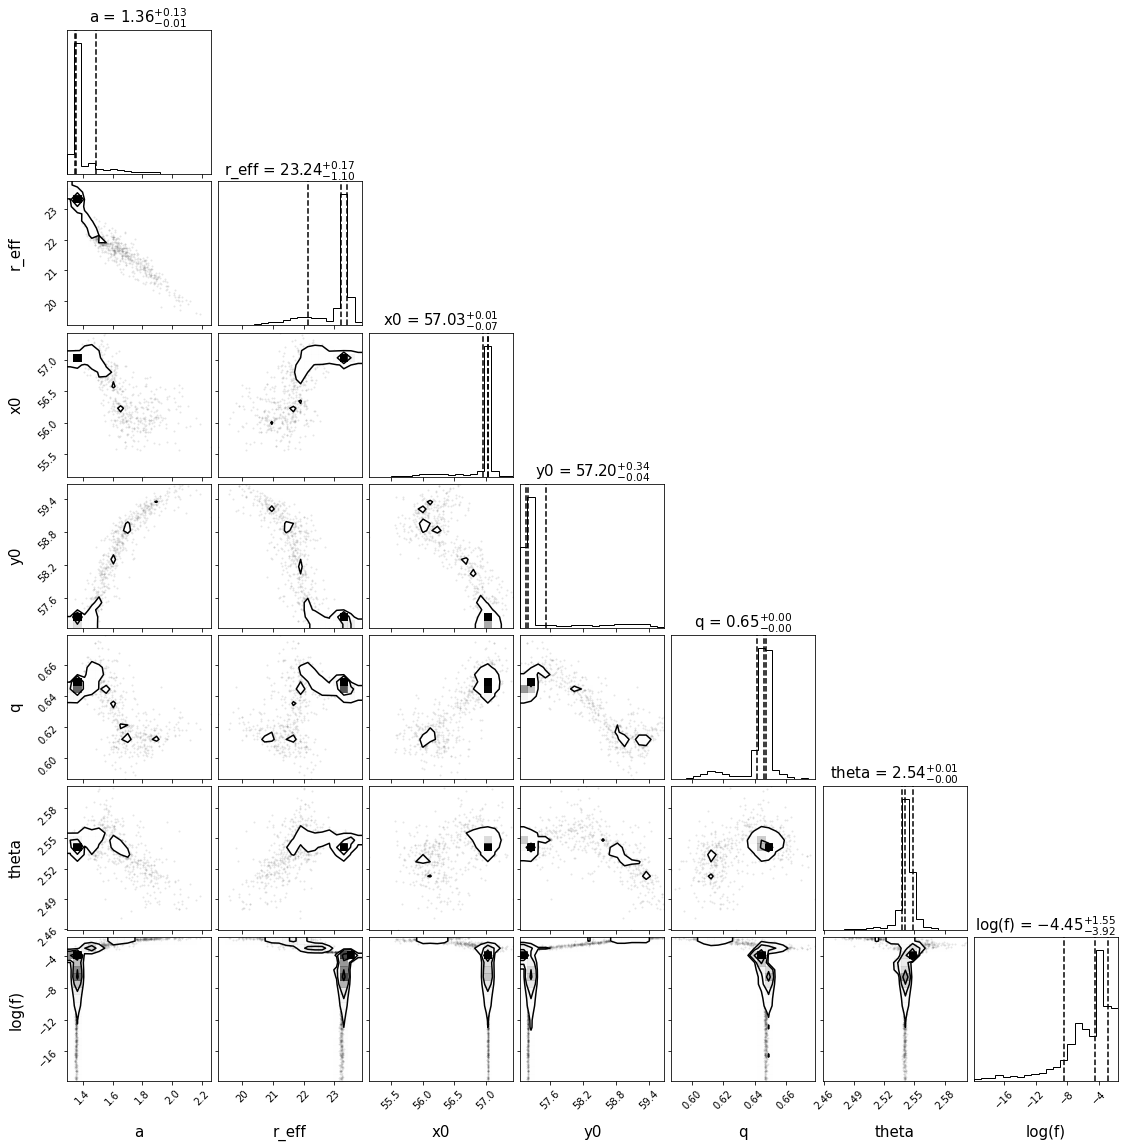

In [357]:
import corner

corner.corner(flat_samples, labels=labels, label_kwargs={"fontsize": 15},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 15});

Make a residual plot, where residual =  (image - model) / noise level. Choose the colormap “RdBu_r” and set `vmax = 3, vmin = -3` in the `matshow()` function. What’s the chi-squared (χ2) value for your fit? What’s the reduced chi-squared?
What is the half-light radius or the effective radius of this galaxy?


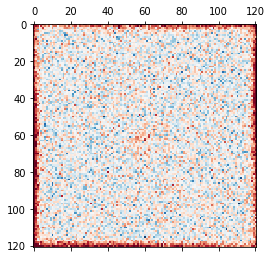

In [368]:
a, r_eff, x0, y0, q, theta, log_f = values[:,1]
fit_model = psf_convolvedmodel(a, r_eff, x0, y0, q, theta)
residual = (flux - fit_model)/noise_level

plt.matshow(residual, cmap="RdBu_r", vmin=-3, vmax=3)

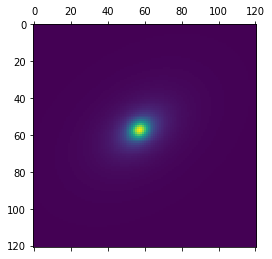

In [371]:
plt.matshow(fit_model)

In [367]:
chi2 = np.sum(((image-fit_model)**2)/fit_model)
print("chi2:",chi2)

Reduced_chi2 = np.mean(((image - fit_model)/noise_level)**2)
print("Reduced chi2:", R_chi2)

chi2: 29.243324289704397
Reduced chi2: 0.9175890318742669


In [369]:
R = np.sqrt(values[4]) * values[1]*pixel_size #in arcsec, by multiplying np.sqrt(q) we are taking the r_eff along the intermadiate axis
text = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}"
text = text.format(R[1],
                   R[1] - R[0],
                   R[2] - R[1],
                       "Reff")
display(Math(text))

<IPython.core.display.Math object>

# end 

remaining are the codes that were not helpful

In [286]:
df = (image.shape[0]-1)*(image.shape[1]-1)

# Chi-Square Goodness of Fit Test
chi_square_test_statistic, p_value = stats.chisquare(mean_image/sum(mean_image), image/sum(image), axis=None)

reduced_chi_square = chi_square_test_statistic/df

# find Chi-Square critical value
chi_square_critical = stats.chi2.ppf(1-0.05, df=df)

print(chi_square_test_statistic,"\n",chi_square_critical,"\n",reduced_chi_square)

79.85813304474004 
 14680.273312517711 
 0.005545703683662503
